In [ ]:
import torch, random, numpy as np
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
print(f"Global seed set to {seed}")

In [ ]:
# !git clone https://github.com/ayannareda/Weather-Detection-Using-Images.git
# url - /kaggle/working/Weather-Detection-Using-Images/Data

### Dataset Loader

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split
import os
from PIL import Image
import torchvision.transforms as transforms

class ImageFilenameDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.files = []
        for label_name in os.listdir(root):
            label_dir = os.path.join(root, label_name)
            if os.path.isdir(label_dir) and label_name.isdigit():
                for fname in sorted(os.listdir(label_dir)):
                    if fname.lower().endswith(('.jpg', '.png')):
                        path = os.path.join(label_dir, fname)
                        self.files.append((path, int(label_name)))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path, label = self.files[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

### Model Architecture


In [2]:
# StarGAN Generator with ResNet blocks and Self-Attention
import torch.nn as nn
import torch

class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(dim, dim, 3, 1, 1), nn.InstanceNorm2d(dim), nn.ReLU(),
            nn.Conv2d(dim, dim, 3, 1, 1), nn.InstanceNorm2d(dim)
        )
    def forward(self, x):
        return x + self.block(x)

class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.query = nn.Conv2d(in_dim, in_dim//8, 1)
        self.key   = nn.Conv2d(in_dim, in_dim//8, 1)
        self.value = nn.Conv2d(in_dim, in_dim,    1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        b, c, h, w = x.size()
        # project
        proj_q = self.query(x).view(b, -1, h*w).permute(0,2,1)   # (B, H*W, C//8)
        proj_k = self.key(x).view(b, -1, h*w)                    # (B, C//8, H*W)
        attn   = torch.softmax(torch.bmm(proj_q, proj_k), dim=-1)  # (B, H*W, H*W)
        proj_v = self.value(x).view(b, -1, h*w)                  # (B, C, H*W)

        # original self‐attended output
        out = torch.bmm(proj_v, attn.permute(0,2,1)).view(b, c, h, w)
        out = self.gamma * out + x

        # compute a single‐channel spatial attention map
        # sum over *source* locations for each *target* pixel
        attn_map = attn.sum(dim=1).view(b, 1, h, w)  # (B,1,H,W)
        # normalize to [0,1]
        attn_map = attn_map / (attn_map.max(dim=-1, keepdim=True)[0].max(dim=-2, keepdim=True)[0] + 1e-8)

        # element‐wise multiply so that high‐attn regions are amplified
        out = out * (1 + attn_map)

        return out

class Generator(nn.Module):
    def __init__(self, in_ch=3, n_classes=5, n_blocks=6):
        super().__init__()
        self.n_classes = n_classes
        # initial conv
        model = [nn.Conv2d(in_ch + n_classes, 64, 7, 1, 3), nn.InstanceNorm2d(64), nn.ReLU()]
        # downsample
        dim = 64
        for _ in range(2):
            model += [nn.Conv2d(dim, dim*2, 4, 2, 1), nn.InstanceNorm2d(dim*2), nn.ReLU()]
            dim *= 2
        # ResNet blocks
        for _ in range(n_blocks):
            model += [ResnetBlock(dim)]
        # insert self-attention layer to focus on weather regions
        model += [SelfAttention(dim)]
        # upsample
        for _ in range(2):
            model += [nn.ConvTranspose2d(dim, dim//2, 4, 2, 1), nn.InstanceNorm2d(dim//2), nn.ReLU()]
            dim //= 2
        # final conv
        model += [nn.Conv2d(dim, in_ch, 7, 1, 3), nn.Tanh()]
        self.model = nn.Sequential(*model)

    def forward(self, x, target_label):
        # target_label: one-hot tensor of shape (B, n_classes)
        b, _, h, w = x.size()
        label_map = target_label.view(b, self.n_classes, 1, 1).expand(b, self.n_classes, h, w)
        inp = torch.cat([x, label_map], dim=1) # [B, in_ch + n_classes, h, w]
        return self.model(inp) # [B, in_ch, h, w]

In [ ]:
# StarGAN Discriminator with adversarial and classification heads
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, in_ch=3, n_classes=5):
        super().__init__()
        layers = []
        dim = in_ch
        for out_dim in [64, 128, 256, 512]:
            layers += [nn.Conv2d(dim, out_dim, 4, 2, 1), nn.LeakyReLU(0.01)]
            dim = out_dim
        self.main = nn.Sequential(*layers)
        self.adv_head = nn.Conv2d(512, 1, 3, 1, 1)
        self.cls_head = nn.Conv2d(512, n_classes, 3, 1, 1)
        self.global_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        h       = self.main(x)           # [B,512,H',W']
        out_adv = self.adv_head(h)       # [B,1, H',W']
        out_cls = self.cls_head(h)       # [B,n_classes,H',W']
        out_cls = self.global_pool(out_cls)  # [B,n_classes,1,1]
        out_cls = out_cls.view(h.size(0), -1)  # [B,n_classes]
        return out_adv, out_cls

### Training Loop

In [ ]:
from tqdm import tqdm
import os
import torch.nn.functional as F
import numpy as np

def train(G, D, train_loader, val_loader, optim_G, optim_D, device,
          epochs=50, lambda_cls=1.0, lambda_rec=10.0,
          checkpoint_dir='checkpoints', resume_path=None):
    # initialize metrics storage
    metrics = {
        'train_adv': [], 'train_cls': [], 'train_rec': [],
        'val_adv':   [], 'val_cls':   [], 'val_rec':   []
    }
    os.makedirs(checkpoint_dir, exist_ok=True)
    start_epoch = 1
    # -- resume if provided --
    if resume_path and os.path.exists(resume_path):
        ckpt = torch.load(resume_path, map_location=device)
        G.load_state_dict(ckpt['G_state']); D.load_state_dict(ckpt['D_state'])
        optim_G.load_state_dict(ckpt['optim_G_state'])
        optim_D.load_state_dict(ckpt['optim_D_state'])
        start_epoch = ckpt.get('epoch', 1) + 1
        print(f"Resuming from epoch {start_epoch}")

    adv_criterion = torch.nn.MSELoss()
    cls_criterion = torch.nn.CrossEntropyLoss()
    rec_criterion = torch.nn.L1Loss()
    G.to(device); D.to(device)

    for epoch in range(start_epoch, epochs+1):
        G.train(); D.train()
        train_stats = {'adv': [], 'cls': [], 'rec': []}
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Train]")
        for real_x, real_lbl in pbar:
            real_x, real_lbl = real_x.to(device), real_lbl.to(device)
            B = real_x.size(0)
            idx = torch.randperm(B); target_lbl = real_lbl[idx]
            target_oh = F.one_hot(target_lbl, G.module.n_classes if isinstance(G, torch.nn.DataParallel) else G.n_classes).float().to(device)
            # print(f"real_lbl: {real_lbl.shape}, target_lbl: {target_lbl.shape}, target_oh: {target_oh.shape}")
            # Discriminator
            fake_x = G(real_x, target_oh).detach()
            optim_D.zero_grad()
            real_adv, real_cls = D(real_x)
            fake_adv, _ = D(fake_x)
            loss_D = adv_criterion(real_adv, torch.ones_like(real_adv)) + \
                     adv_criterion(fake_adv, torch.zeros_like(fake_adv)) + \
                     lambda_cls * cls_criterion(real_cls, real_lbl)
            loss_D.backward(); optim_D.step()
            
            # Generator
            optim_G.zero_grad()
            fake_x = G(real_x, target_oh)
            adv_out, cls_out = D(fake_x)
            rec_lbl_oh = F.one_hot(real_lbl, G.module.n_classes if isinstance(G, torch.nn.DataParallel) else G.n_classes).float().to(device)
            rec_x = G(fake_x, rec_lbl_oh)
            loss_G = adv_criterion(adv_out, torch.ones_like(adv_out)) + \
                     lambda_cls * cls_criterion(cls_out, target_lbl) + \
                     lambda_rec * rec_criterion(rec_x, real_x)
            loss_G.backward(); optim_G.step()

            # collect stats
            train_stats['adv'].append(loss_G.item())
            train_stats['cls'].append(cls_criterion(cls_out, target_lbl).item())
            train_stats['rec'].append(rec_criterion(rec_x, real_x).item())
            pbar.set_postfix({k: np.mean(v) for k, v in train_stats.items()})

        # Validation
        G.eval(); D.eval()
        val_stats = {'adv': [], 'cls': [], 'rec': []}
        with torch.no_grad():
            vbar = tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [Val]")
            for real_x, real_lbl in vbar:
                real_x, real_lbl = real_x.to(device), real_lbl.to(device)
                B = real_x.size(0)
                idx = torch.randperm(B); target_lbl = real_lbl[idx]
                target_oh = F.one_hot(target_lbl, G.module.n_classes if isinstance(G, torch.nn.DataParallel) else G.n_classes).float().to(device)
                fake_x = G(real_x, target_oh)
                adv_out, cls_out = D(fake_x)
                rec_lbl_oh = F.one_hot(real_lbl, G.module.n_classes if isinstance(G, torch.nn.DataParallel) else G.n_classes).float().to(device)
                rec_x = G(fake_x, rec_lbl_oh)
                val_stats['adv'].append(adv_criterion(adv_out, torch.ones_like(adv_out)).item())
                val_stats['cls'].append(cls_criterion(cls_out, target_lbl).item())
                val_stats['rec'].append(rec_criterion(rec_x, real_x).item())
                vbar.set_postfix({k: np.mean(v) for k, v in val_stats.items()})

        # Log metrics
        print(f"Epoch {epoch}: Train -> adv={np.mean(train_stats['adv']):.4f}, ",
              f"cls={np.mean(train_stats['cls']):.4f}, rec={np.mean(train_stats['rec']):.4f}")
        print(f"           Val   -> adv={np.mean(val_stats['adv']):.4f}, ",
              f"cls={np.mean(val_stats['cls']):.4f}, rec={np.mean(val_stats['rec']):.4f}")

        # Save checkpoint
        if epoch % 5 == 0 or epoch == epochs:
            ckpt_path = os.path.join(checkpoint_dir, f"sa_ckpt_epoch_{epoch}.pt")
            torch.save({
                'epoch': epoch,
                'G_state': G.state_dict(),
                'D_state': D.state_dict(),
                'optim_G_state': optim_G.state_dict(),
                'optim_D_state': optim_D.state_dict()
            }, ckpt_path)
        # append epoch metrics
        metrics['train_adv'].append(np.mean(train_stats['adv']))
        metrics['train_cls'].append(np.mean(train_stats['cls']))
        metrics['train_rec'].append(np.mean(train_stats['rec']))
        metrics['val_adv'].append(np.mean(val_stats['adv']))
        metrics['val_cls'].append(np.mean(val_stats['cls']))
        metrics['val_rec'].append(np.mean(val_stats['rec']))
    # end epochs
    return metrics

In [ ]:
import pickle

import torch.nn as nn
# Example usage of train_starGAN function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate models
G = Generator().to(device)
D = Discriminator().to(device)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    G = nn.DataParallel(G)
    D = nn.DataParallel(D)

# Optimizers
optim_G = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optim_D = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Transforms
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# Create dataset and split into train and validation sets
BATCH_SIZE = 32
dataset = ImageFilenameDataset('/kaggle/working/Weather-Detection-Using-Images/Data', transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Call train_starGAN function
metrics = train(
    G, D,
    train_loader, val_loader,
    optim_G, optim_D,
    device,
    epochs=80,
    checkpoint_dir='checkpoints',
    resume_path="checkpoints/sa_ckpt_epoch_30.pt"
)

# Save metrics for later use

with open('sa_metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)

---

## Inference time

/tmp/ipykernel_107995/1792111913.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('./checkpoints/sa_ckpt_epoch_60.pt', map_location=device)


Using 2 GPUs


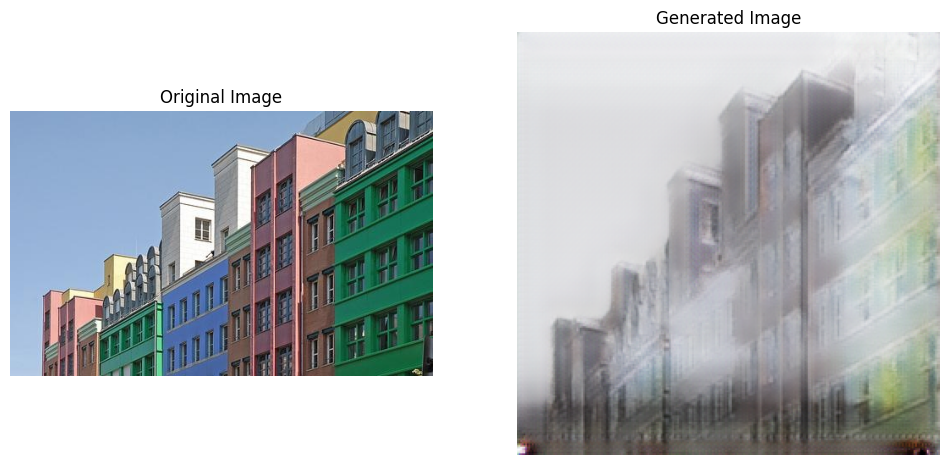

In [18]:
# Inference cell

import torch
import os
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1) define transforms (must match training)
transform_in = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# 2) helper to undo Normalize
unnormalize = transforms.Normalize(
    mean=[-1.0, -1.0, -1.0],
    std =[2.0,  2.0,  2.0]
)

# 3) load checkpoint & build model
ckpt = torch.load('./checkpoints/sa_ckpt_epoch_60.pt', map_location=device)
# If model was trained with DataParallel, wrap before loading state dict

G = Generator().to(device)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    G = nn.DataParallel(G)
G.load_state_dict(ckpt['G_state'])
G.eval()

# 4) inference function
# def infer(img_path, target_label):
#     img = Image.open(img_path).convert('RGB')
#     x   = transform_in(img).unsqueeze(0).to(device)
#     lbl = torch.tensor([target_label], device=device)
#     with torch.no_grad():
#         fake = G(x, target_label=F.one_hot(lbl, num_classes=G.n_classes).float().to(device))
#     # undo normalization & clamp
#     fake = unnormalize(fake.squeeze(0).cpu()).clamp(0,1)
#     return img, transforms.ToPILImage()(fake)
def infer(img_path, target_label):
    img = Image.open(img_path).convert('RGB')
    x = transform_in(img).unsqueeze(0).to(device)
    lbl = torch.tensor([target_label], device=device)
    # handle DataParallel vs single‐GPU
    num_classes = G.module.n_classes if hasattr(G, 'module') else G.n_classes
    lbl_onehot = F.one_hot(lbl, num_classes=num_classes).float().to(device)
    with torch.no_grad():
        fake = G(x, target_label=lbl_onehot)
    # undo normalization & clamp
    fake = unnormalize(fake.squeeze(0).cpu()).clamp(0,1)
    return img, transforms.ToPILImage()(fake)

# 5) run on an example
base_path = '/kaggle/working/Weather-Detection-Using-Images/Data'
img_path = os.path.join(base_path, '1', '2712042504.jpg')

original, generated = infer(img_path, target_label=4)    # choose your label index

# Display side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(original); axes[0].axis('off'); axes[0].set_title('Original Image')
axes[1].imshow(generated); axes[1].axis('off'); axes[1].set_title('Generated Image')
plt.show()